# Nilearn

There are many helpful tutorials on the nilearn website. Today, we will go through a few of them.

Nilearn website: http://nilearn.github.io/auto_examples/

In [1]:
# GoogleColab: make sure you run the notebook using Python 3

# *** Run this cell if you are using Google Colab. You don't need to run this cell if you are running the notebook locally ***

!pip install nilearn

!wget https://raw.githubusercontent.com/amandakeasson/RRI_ML_workshop/master/haxby_graph-net_weights.nii
!wget https://raw.githubusercontent.com/amandakeasson/RRI_ML_workshop/master/adhd_fc_matrices.mat



You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
--2019-05-10 14:59:35--  https://raw.githubusercontent.com/amandakeasson/RRI_ML_workshop/master/haxby_graph-net_weights.nii
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.64.133, 151.101.128.133, 151.101.192.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.64.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1311072 (1.2M) [application/octet-stream]
Saving to: ‘haxby_graph-net_weights.nii.1’

haxby_graph-net_wei 100%[===================>]   1.25M  1.35MB/s    in 0.9s    

2019-05-10 14:59:36 (1.35 MB/s) - ‘haxby_graph-net_weights.nii.1’ saved [1311072/1311072]

--2019-05-10 14:59:36--  https://raw.githubusercontent.com/amandakeasson/RRI_ML_workshop/master/adhd_fc_matrices.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.64.13

In [2]:
# import packages
from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn import plotting
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


/home/amandae/anaconda3/envs/nibeta/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/amandae/anaconda3/envs/nibeta/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/amandae/anaconda3/envs/nibeta/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
# Fetch data using nilearn dataset fetcher
haxby_dataset = datasets.fetch_haxby()

# Classifying representations of different visual stimuli

<b>Sources</b>:  

http://nilearn.github.io/auto_examples/plot_decoding_tutorial.html#sphx-glr-auto-examples-plot-decoding-tutorial-py  

http://nilearn.github.io/auto_examples/02_decoding/plot_haxby_different_estimators.html#sphx-glr-auto-examples-02-decoding-plot-haxby-different-estimators-py

In [4]:
# load labels
df = pd.read_csv(haxby_dataset.session_target[0], sep=" ")

stimuli = df['labels']
print(stimuli.unique())

['rest' 'scissors' 'face' 'cat' 'shoe' 'house' 'scrambledpix' 'bottle'
 'chair']


In [5]:
# choose stimuli of interest
task_mask = stimuli.isin(['face', 'house', 'cat'])

# extract tags indicating to which acquisition run a tag belongs
session_labels = df['chunks'][task_mask]

print(session_labels)

21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
35       0
36       0
37       0
38       0
39       0
40       0
41       0
42       0
43       0
63       0
64       0
65       0
66       0
67       0
68       0
69       0
70       0
71       0
127      1
128      1
129      1
        ..
1308    10
1309    10
1310    10
1352    11
1353    11
1354    11
1355    11
1356    11
1357    11
1358    11
1359    11
1360    11
1394    11
1395    11
1396    11
1397    11
1398    11
1399    11
1400    11
1401    11
1402    11
1423    11
1424    11
1425    11
1426    11
1427    11
1428    11
1429    11
1430    11
1431    11
Name: chunks, Length: 324, dtype: int64


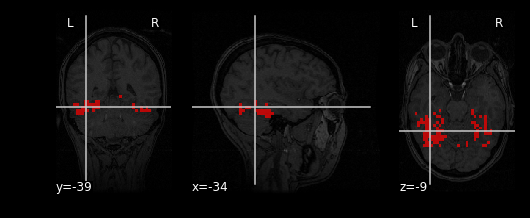

In [6]:
# plot mask of ventral temporal stream 

mask_filename = haxby_dataset.mask_vt[0]
plotting.plot_roi(mask_filename, bg_img=haxby_dataset.anat[0],cmap='autumn');


Now we will mask the data using two masks:  
1) Mask the observations using the `task_mask` (restrict observations to faces, houses and cats  
2) Mask the features (in this case, voxels) using the `voxel_masker` (restrict features to voxels in the ventral temporal mask)

In [7]:
voxel_masker = NiftiMasker(mask_img=mask_filename, standardize=True)

func_filename = haxby_dataset.func[0]

masked_timecourses = voxel_masker.fit_transform(func_filename)[task_mask]

print('Number of time points:', masked_timecourses.shape[0])
print('Number of voxels:', masked_timecourses.shape[1])

Number of time points: 324
Number of voxels: 464


In [8]:
# Define classifiers

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

svm = SVC(C=100., kernel="linear")
logistic = LogisticRegression(C=1., penalty="l2", solver='liblinear')
random_forest = RandomForestClassifier(n_estimators=10)

# Make a dictionary to hold all the classifiers
classifiers = {'SVM': svm,
               'LogReg': logistic,
               'Random_Forest': random_forest}

In [9]:
# train models

# Make a data splitting object for cross validation
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
cv = LeaveOneGroupOut()

import time

classifiers_scores = {}
categories = stimuli[task_mask].unique()

for classifier_name, classifier in sorted(classifiers.items()):
    classifiers_scores[classifier_name] = {}
    print(70 * '_')

    for category in categories:
        classification_target = stimuli[task_mask].isin([category])
        classifiers_scores[classifier_name][category] = cross_val_score(
            classifier,
            masked_timecourses,
            classification_target,
            cv=cv,
            groups=session_labels,
            scoring="accuracy",
        )

        print("%10s: %14s -- scores: %1.2f +- %1.2f" %
            (classifier_name, category,
                classifiers_scores[classifier_name][category].mean(),
                classifiers_scores[classifier_name][category].std()))

______________________________________________________________________
    LogReg:           face -- scores: 0.69 +- 0.18
    LogReg:            cat -- scores: 0.80 +- 0.14
    LogReg:          house -- scores: 0.94 +- 0.12
______________________________________________________________________
Random_Forest:           face -- scores: 0.69 +- 0.15
Random_Forest:            cat -- scores: 0.64 +- 0.08
Random_Forest:          house -- scores: 0.81 +- 0.10
______________________________________________________________________
       SVM:           face -- scores: 0.78 +- 0.13
       SVM:            cat -- scores: 0.82 +- 0.11
       SVM:          house -- scores: 0.98 +- 0.07


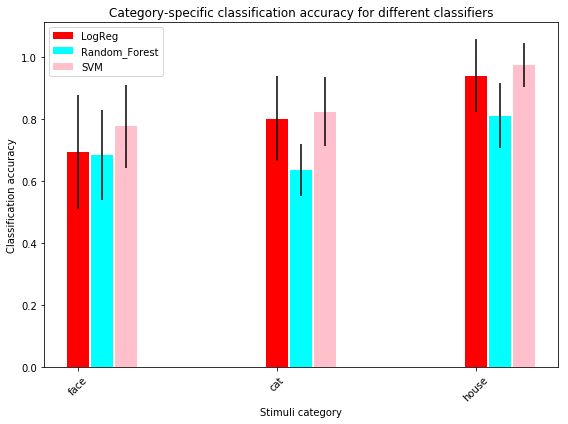

In [10]:
# make a bar plot

plt.figure(figsize=(8,6))

tick_position = np.arange(len(categories))
plt.xticks(tick_position, categories, rotation=45)

for color, classifier_name in zip(['red', 'cyan', 'pink'],sorted(classifiers)):
    score_means = [classifiers_scores[classifier_name][category].mean()
                   for category in categories]
    score_std = [np.std(classifiers_scores[classifier_name][category]) for category in categories]
    plt.bar(tick_position, score_means, label=classifier_name,
            width=.11, color=color, yerr=score_std)
    tick_position = tick_position + .12

plt.ylabel('Classification accuracy')
plt.xlabel('Stimuli category')
plt.ylim(ymin=0)
plt.legend(loc='best')
plt.title('Category-specific classification accuracy for different classifiers')
plt.tight_layout()

In [11]:
# plot face vs. house maps for SVM

# Use the average EPI as a background
from nilearn import image
mean_epi_img = image.mean_img(func_filename)

# Restrict the decoding to face vs house
condition_mask = stimuli.isin(['face', 'house'])
masked_timecourses = masked_timecourses[
    condition_mask[task_mask]]
stimuli = (stimuli[condition_mask] == 'face')

# Transform the stimuli to binary values
stimuli.astype(np.int);

In [14]:
svm.fit(masked_timecourses, stimuli)
weights = svm.coef_
print(weights.shape)

(1, 464)


We can see that we have one weight per voxel. Now, we'll want to convert the weights back into a Nifti image.  

We can accomplish this using `inverse_transform` on `voxel_masker`.  

Then, we can retrieve the image data by calling `.get_fdata()`

In [15]:
weight_img = voxel_masker.inverse_transform(weights)
weight_map = weight_img.get_fdata()

print('Shape of nifti data:', weight_map.shape, '\n')

print('Nifti image information:', '\n')
print(weight_img)

Shape of nifti data: (40, 64, 64, 1) 

Nifti image information: 

<class 'nibabel.nifti1.Nifti1Image'>
data shape (40, 64, 64, 1)
affine: 
[[  -3.5      0.       0.      68.25 ]
 [   0.       3.75     0.    -118.125]
 [   0.       0.       3.75  -118.125]
 [   0.       0.       0.       1.   ]]
metadata:
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [ 4 40 64 64  1  1  1  1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float64
bitpix          : 64
slice_start     : 0
pixdim          : [-1.    3.5   3.75  3.75  1.    1.    1.    1.  ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
g

Now we can plot the weights using `plot_stat_map`.

0.08393504439703334


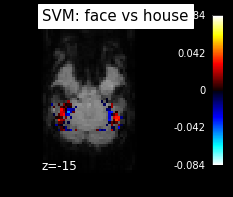

In [16]:
from nilearn.plotting import plot_stat_map, show

threshold = np.max(np.abs(weight_map)) * 0.01
print(np.max(np.abs(weight_map)))

plot_stat_map(weight_img, bg_img=mean_epi_img,
              display_mode='z', cut_coords=[-15],
              threshold=threshold,
              title='%s: face vs house' % classifier_name)
show()

# SpaceNet

Source: http://nilearn.github.io/decoding/space_net.html#space-net

SpaceNet implements spatial penalties which improve brain decoding power as well as decoder maps.  

We will run SpaceNet using the `graph-net` penalty (see [Grosenick et al. 2013](https://www.ncbi.nlm.nih.gov/pubmed/23298747)).  

Using graph-net, we can obtain "sparse but structured solutions by combining structured graph constraints (based on knowledge about coefficient smoothness or connectivity) with a global sparsity-inducing prior that automatically selects important variables." (Grosenick et al., 2013)


#### Full tutorial:

http://nilearn.github.io/auto_examples/02_decoding/plot_haxby_space_net.html#sphx-glr-auto-examples-02-decoding-plot-haxby-space-net-py

In [17]:
# Restrict to face and house conditions
stimuli = df['labels']
condition_mask = stimuli.isin(['face', 'house'])

# Split data into train and test samples, using the chunks
condition_mask_train = (condition_mask) & (df['chunks'] <= 6)
condition_mask_test = (condition_mask) & (df['chunks'] > 6)

# Apply this sample mask to X (fMRI data) and y (behavioral labels)
# Because the data is in one single large 4D image, we need to use index_img to do the split easily
from nilearn.image import index_img
func_filenames = haxby_dataset.func[0]
X_train = index_img(func_filenames, condition_mask_train)
X_test = index_img(func_filenames, condition_mask_test)
y_train = stimuli[condition_mask_train]
y_test = stimuli[condition_mask_test]

# Compute the mean epi to be used for the background of the plotting
from nilearn.image import mean_img
background_img = mean_img(func_filenames)

In [ ]:
# don't run this cell

from nilearn.decoding import SpaceNetClassifier

# Fit model on train data and predict on test data
decoder = SpaceNetClassifier(memory="nilearn_cache", penalty='graph-net')
decoder.fit(X_train, y_train)
y_pred = decoder.predict(X_test)
accuracy = (y_pred == y_test).mean() * 100.
print("Graph-net classification accuracy : %g%%" % accuracy)

In [ ]:
# don't run this cell

coef_img = decoder.coef_img_
# Save the coefficients to a nifti file
coef_img.to_filename('haxby_graph-net_weights.nii')

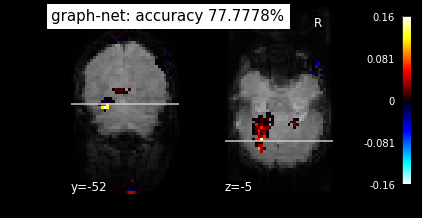

In [20]:
from nilearn.image import load_img
accuracy = 77.7778
coef_nii = load_img('haxby_graph-net_weights.nii')
plot_stat_map(coef_nii, background_img,
              title="graph-net: accuracy %g%%" % accuracy,
              cut_coords=(-52, -5), display_mode="yz");

# Let's look at some brain networks!

<b>Source</b>:  
http://nilearn.github.io/auto_examples/03_connectivity/plot_sphere_based_connectome.html#sphx-glr-auto-examples-03-connectivity-plot-sphere-based-connectome-py

First, we will extract functional connectivity matrices from the Power atlas for a single participant from the ADHD dataset.  


In [19]:
adhd = datasets.fetch_adhd(n_subjects=1)
fmri_filename = adhd.func[0]
confounds_filename = adhd.confounds[0]

In [20]:
# fetch coordinates of Power atlas
power = datasets.fetch_coords_power_2011()
coords = np.vstack((power.rois['x'], power.rois['y'], power.rois['z'])).T
print(coords.shape)

(264, 3)


In [21]:
# define a spheres masker

from nilearn import input_data

spheres_masker = input_data.NiftiSpheresMasker(seeds=coords, smoothing_fwhm=4, radius=5.,
    detrend=True, standardize=True, low_pass=0.1, high_pass=0.01, t_r=2.5)

# mask the data to obtain the time series
timeseries = spheres_masker.fit_transform(fmri_filename, confounds=confounds_filename)

Correlation matrices shape:  (1, 264, 264)


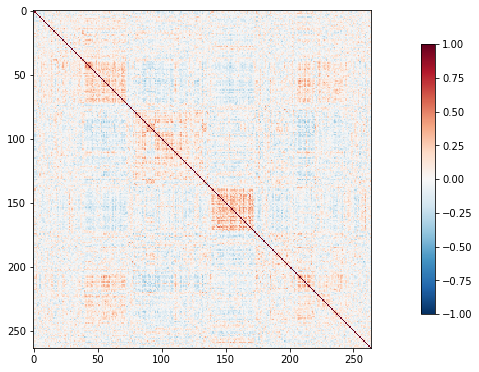

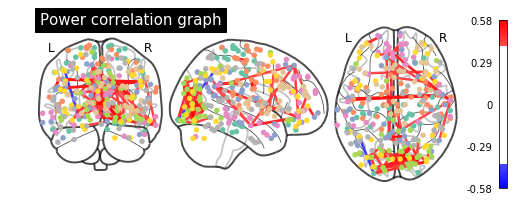

In [22]:
# define FC using Pearson correlation coefficient

#FC = np.corrcoef(timeseries.T)

from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
test_subj = []
test_subj.append(timeseries)
correlation_matrices = correlation_measure.fit_transform(test_subj)
print('Correlation matrices shape: ', correlation_matrices.shape)

fc_subj1 = correlation_matrices[0,:,:]

plotting.plot_matrix(fc_subj1, vmin=-1., vmax=1., colorbar=True)

# keep only the strongest connections
# if edge_threshold is a percentage: only the edges with an absolute value above the given percentile will be shown
plotting.plot_connectome(fc_subj1, coords, title='Power correlation graph',
                         edge_threshold='99.8%', node_size=20, colorbar=True)
show()

# Group-level analysis: ADHD dataset

Source: http://nilearn.github.io/auto_examples/03_connectivity/plot_group_level_connectivity.html#sphx-glr-auto-examples-03-connectivity-plot-group-level-connectivity-py

This analysis is performed on 20 participants. It takes a long time to download and extract the data, so I have performed those steps and saved the connectivity matrices, which we will load.  

The atlas used here is the MSDL atlas:

In [23]:
msdl_data = datasets.fetch_atlas_msdl()
msdl_coords = msdl_data.region_coords
n_regions = len(msdl_coords)
networks = []
for network in msdl_data.networks:
    networks.append(network.decode("utf-8"))
print(networks)

['Aud', 'Aud', 'Striate', 'DMN', 'DMN', 'DMN', 'DMN', 'Occ post', 'Motor', 'R V Att', 'R V Att', 'R V Att', 'R V Att', 'Basal', 'L V Att', 'L V Att', 'L V Att', 'D Att', 'D Att', 'Vis Sec', 'Vis Sec', 'Vis Sec', 'Salience', 'Salience', 'Salience', 'Temporal', 'Temporal', 'Language', 'Language', 'Language', 'Language', 'Language', 'Cereb', 'Dors PCC', 'Cing-Ins', 'Cing-Ins', 'Cing-Ins', 'Ant IPS', 'Ant IPS']


Load the ADHD functional connectivity (FC), which has already been prepared.  

We will compare different connectivity metrics: correlation, partial correlation, and tangent. The tangent metric models individual FC as perturbations of the group FC matrix.

In [24]:
# load the ADHD data

from scipy.io import loadmat

mat = loadmat('adhd_fc_matrices.mat')
conn_mat_tmp = mat['connectivity_biomarkers']
conn_mat_full_tmp = mat['connectivity_biomarkers_2D']
labels = mat['labels'][0].tolist()
sites = mat['sites'].tolist()

kinds = ['correlation', 'partial correlation', 'tangent']

conn_mat = {}
conn_mat_full = {}
for kind in kinds:
    tmp = conn_mat_tmp[kind]
    tmp2 = tmp[0][0]
    conn_mat[kind] = tmp2
    tmp = conn_mat_full_tmp[kind]
    tmp2 = tmp[0][0]
    conn_mat_full[kind] = tmp2
    

In [25]:
# run a model to see which method is best

from sklearn.model_selection import StratifiedKFold

classes = ['{0}{1}'.format(site_name, adhd_label)
           for site_name, adhd_label in zip(sites, labels)]
cv = StratifiedKFold(n_splits=3)

Run the classifier for each connectivity measure.

In [26]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

mean_scores = []
std_scores = []
for kind in kinds:
    svc = LinearSVC(random_state=0)
    cv_scores = cross_val_score(svc, conn_mat[kind],
                                y=labels, cv=cv,
                                groups=labels, scoring='accuracy')
    mean_scores.append(cv_scores.mean())
    std_scores.append(np.std(cv_scores))

Now we can plot the CV accuracy for each connectivity measure.

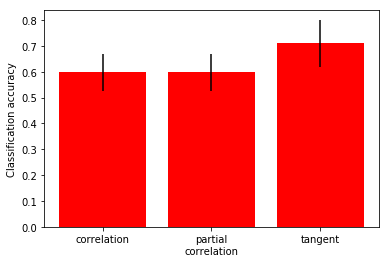

In [27]:

plt.figure(figsize=(6, 4))
plt.bar(np.arange(3), mean_scores, align='center', yerr=std_scores,color='red')
xticks = [kind.replace(' ', '\n') for kind in kinds]
plt.xticks(np.arange(3), xticks) # typo: should be xticks
plt.ylabel('Classification accuracy')
plt.show()

# Neuropredict

The final package we will look at today is called Neuropredict. It was developed by Dr. Pradeep Raamana.  

You can find the code here: https://github.com/raamana/neuropredict.  

Check out https://raamana.github.io/neuropredict for full documentation.  

Neuropredict makes it easy to run machine learning pipelines on neuroimaging data (or any data, really!).  

We will analyze the above Haxby data using Neuropredict. First, we need to prepare the data so that it is in the correct format for Neuropredict.

We will create pandas dataframes, then save the X (time points x voxels) and y (stimuli labels) as .csv files.

In [ ]:
# prepare data for neuropredict

labels = stimuli[task_mask]

obs_names = []
f, c, h, = 0, 0, 0
for l in labels:
    if l == 'face':
        f+= 1
        obs_names.append('face' + str(f))
    elif l == 'cat':
        c+= 1
        obs_names.append('cat' + str(c))
    elif l == 'house':
        h+=1
        obs_names.append('house' + str(h))
        
df_features = pd.DataFrame(masked_timecourses)
df_labels = pd.DataFrame(np.column_stack([obs_names, labels]))
        
df_features.to_csv('neuropredict_features.csv', header=False, index=False)
df_labels.to_csv('neuropredict_labels.csv', header=False, index=False)

Then, all you have to do to run neuropredict is run the following command in your terminal/command prompt:  

`neuropredict -m neuropredict_labels.csv -d neuropredict_features.csv`

Or, you can run it in a Jupyter notebook by adding an exclamation mark at the front of the command: 

`!neuropredict -m neuropredict_labels.csv -d neuropredict_features.csv`

This takes around an hour to run, so I've uploaded the results for us to take a look at.

### Outputs from Neuropredict:
* Accuracy distributions
* Comparison of misclassification rates
* Confusion matrices
* Feature importance

We can also load the file called `best_parameter_values.pkl` to see the optimal parameters.  

In this, case, we have:  
* Max features:  the number of features (or fraction of features) to consider when looking for the best split
* Min samples per leaf:  the minimum number of samples required to be at a leaf node; a split will only be made if it leaves at least this number of training samples in each of the left and right branches
* N estimators:  the number of trees in the forest  
* Criterion:  Gini impurity (a measure the likelihood of an incorrect classification_

In [28]:
import pickle
best_params = pickle.load(open("neuropredict_results/cat_face_house/best_parameter_values.pkl", "rb"))
best_params

{'neuropredict_features': {'random_forest_clf__criterion': 'gini',
  'random_forest_clf__max_features': 0.25,
  'random_forest_clf__min_samples_leaf': 1,
  'random_forest_clf__n_estimators': 250}}

In [35]:
from sklearn.ensemble import RandomForestClassifier
RandomForestClassifier?